In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler#标准化
from sklearn.metrics import adjusted_rand_score, silhouette_score#兰德指数与轮廓系数

In [102]:
#Kmeans类定义
class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=3):  #经过之前的作业，感觉随机种子小一点比较好,就不用666了
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None  #聚类中心的坐标
        self.inertia = None    #所有样本到质心的曼哈顿距离之和


    def kmeans_plus_plus_init(self,X):
        #随机选取第一个质心
        rng = np.random.RandomState(self.random_state)
        centroids =[X[rng.choice(X.shape[0])]]

        #计算每个样本到达最近质心的曼哈顿距离
        for _ in range(self.n_clusters-1):
            dist=np.array([np.min(np.sum(np.abs(x-centroids),axis=1)) for x in X])
            prob=dist**2/(dist**2).sum()  #概率与距离的平方为正比
            sum_prob=prob.cumsum()
            new_r=rng.rand()
            #选择下一个质心
            for j,p in enumerate(sum_prob):
                if new_r<p:
                    centroids.append(X[j])
                    break
        return np.array(centroids)


    def assingn_cluster(self,X):#计算每个样本到每个质心的曼哈顿距离   板块
        distances=np.sum(np.abs(X[:,np.newaxis]-self.centroids),axis=2)
        return np.argmin(distances,axis=1)#返回距离最小的簇


    def compute_centroids(self,X,labels):#计算新质心     板块
        new_centroids=np.zeros((self.n_clusters,X.shape[1]))
        for i in range(self.n_clusters):
            cluster_samples=X[labels==i]
            if len(cluster_samples)==0:#遇到空簇时候随机选择一个样本
                new_centroids[i]=X[np.random.chice(X.shape[0])]
            else:new_centroids[i]=np.median(cluster_samples,axis=0)
        return new_centroids


    def fit(self,X):
        self.centroids = self.kmeans_plus_plus_init(X)#初始化质心

        for _ in range(self.max_iter):
            labels=self.assingn_cluster(X)#簇标签
            new_centroids=self.compute_centroids(X,labels)#新质心，采用中位数
#收敛条件：质心变化小于临界值
            if np.allclose(self.centroids,new_centroids,atol=1e-3):
                break
            self.centroids=new_centroids
#计算曼哈顿距离
        self.inertia=sum(np.min(np.sum(np.abs(x-self.centroids),axis=1)) for x in X)

    def predict(self,X):
        return self.assingn_cluster(X)

In [103]:
iris=load_iris()
X=iris.data
y=iris.target
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)


#开始训练
kmeans=KMeans(n_clusters=3, random_state=3)
kmeans.fit(X_scaled)
labels=kmeans.predict(X_scaled)#为样本分配簇

#兰德指数与轮廓系数
ari=adjusted_rand_score(y,labels)
sil=silhouette_score(X_scaled,labels)

兰德指数：0.6637
轮廓系数：0.4489
优化后聚类中心坐标:
[[5.8 2.7 4.4 1.3]
 [5.  3.4 1.5 0.2]
 [6.7 3.  5.5 2. ]]

样本分布:
{np.int64(0): np.int64(51), np.int64(1): np.int64(50), np.int64(2): np.int64(49)}


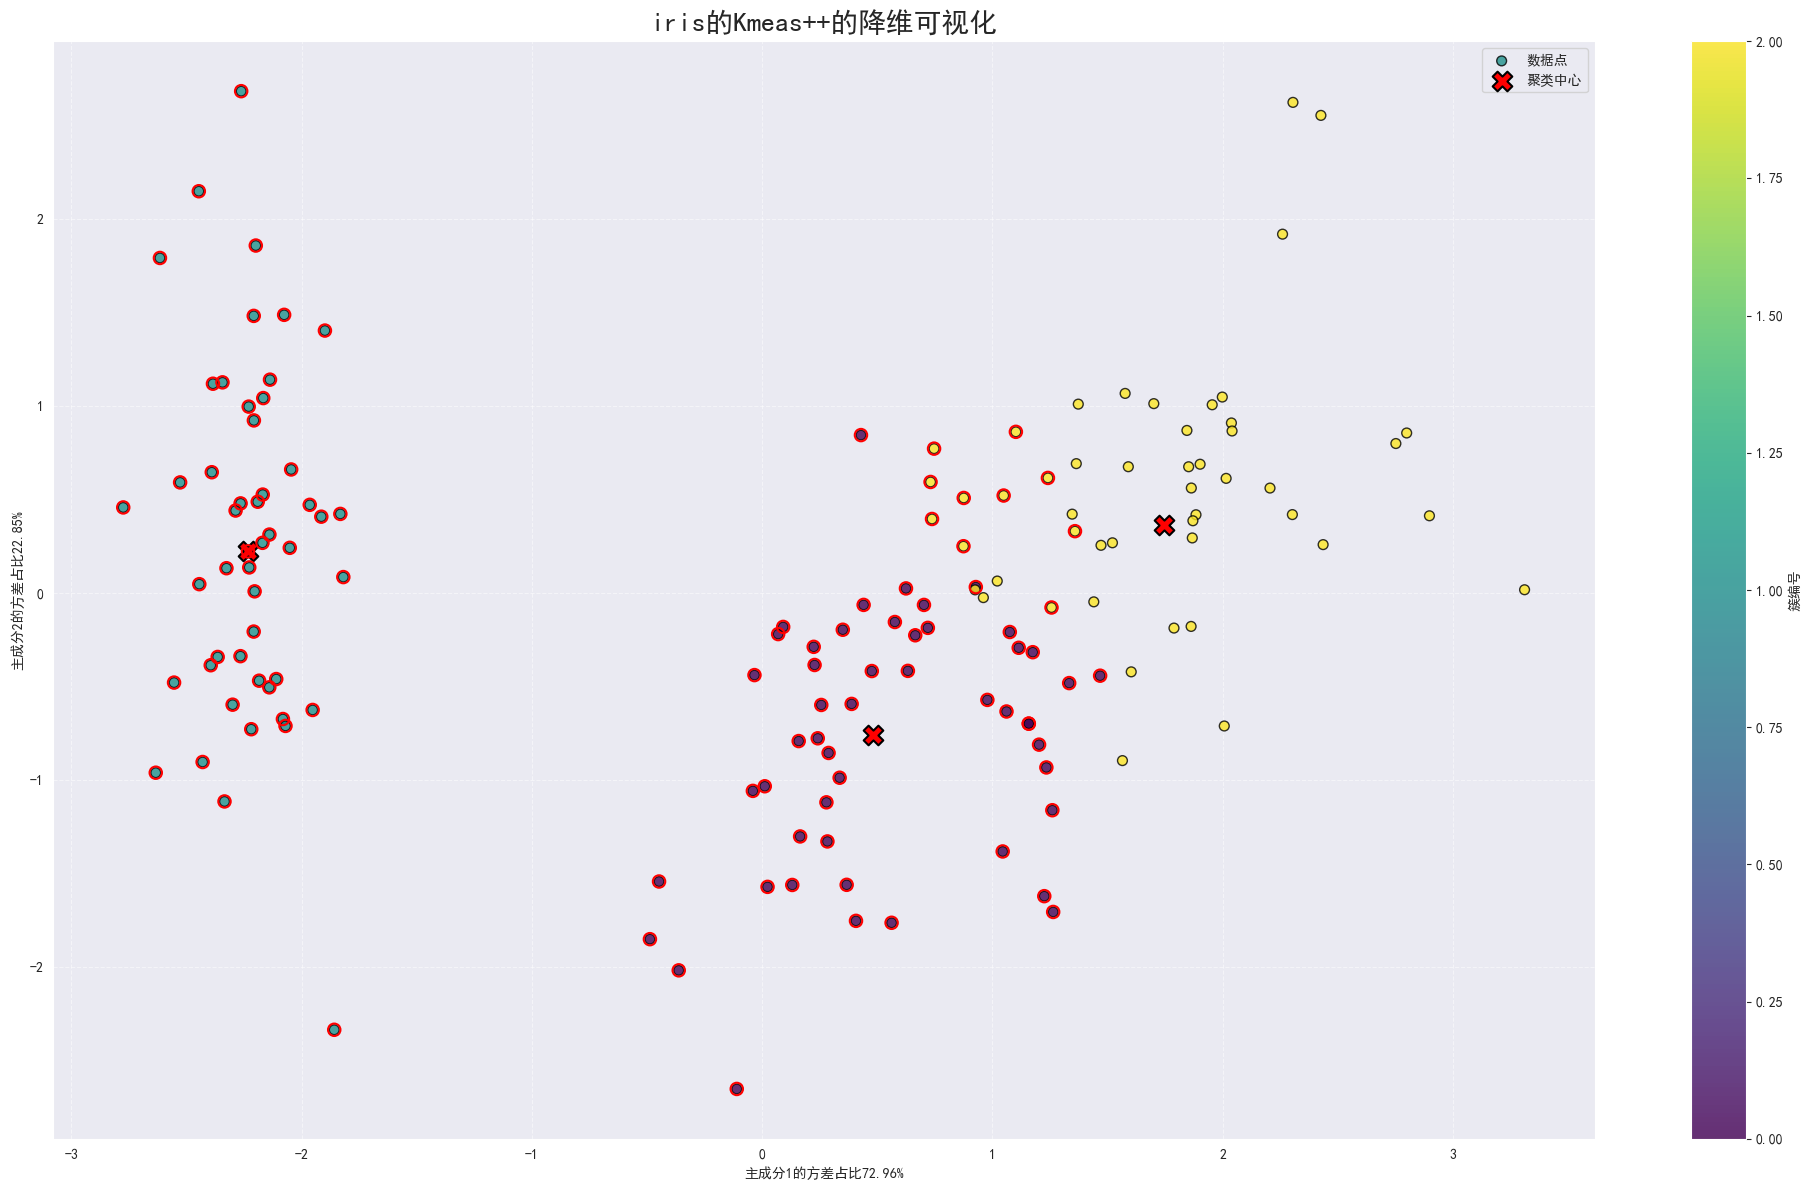

In [104]:
#结果与可视化
from sklearn.decomposition import PCA#降维可视化

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print(f"兰德指数：{ari:.4f}")
print(f"轮廓系数：{sil:.4f}")
print("优化后聚类中心坐标:")
print(scaler.inverse_transform(kmeans.centroids))  # 反标准化显示原始尺度
print("\n样本分布:")
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))


#可视化部分PCA降维
pca=PCA(n_components=2)
X_pca=pca.fit_transform(X_scaled)
centroids_pca=pca.transform(kmeans.centroids)

plt.figure(figsize=(20,12))
scatter=plt.scatter(X_pca[:,0],X_pca[:,1],c=labels,cmap='viridis',alpha=0.8,edgecolor='k',s=50,label='数据点')
centroid_scatter=plt.scatter(centroids_pca[:,0],centroids_pca[:,1],c='red',marker='X',s=200,edgecolor='black',linewidth=1.5,label='聚类中心')

plt.title('iris的Kmeas++的降维可视化',fontsize=20)
plt.xlabel(f'主成分1的方差占比{pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'主成分2的方差占比{pca.explained_variance_ratio_[1]*100:.2f}%')
plt.grid(True,linestyle='--',alpha=0.5)


plt.legend(handles=[scatter,centroid_scatter],loc='upper right')
plt.colorbar(scatter,label='簇编号')

#误分类区域
for i, (true_label, pred_label) in enumerate(zip(y, labels)):
    if true_label != pred_label:
        plt.scatter(X_pca[i, 0], X_pca[i,1],facecolors='none', edgecolors='r',s=80, linewidth=1.5)

plt.tight_layout()
plt.show()